### Importing Libraries.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader,Subset
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchsummary import summary
from tqdm import tqdm

### Downloading the datasets.

In [2]:
# Downloading CIFAR10 dataset.
train_data = CIFAR10('mnist', train = True, download = True, transform=ToTensor())
test_data  = CIFAR10('mnist', train = False, download = True, transform = ToTensor())


Files already downloaded and verified
Files already downloaded and verified


### Checking an image.

6


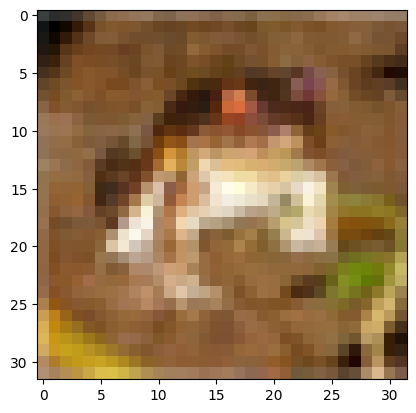

In [3]:
# Image label pairs.
print(train_data[0][1])
plt.imshow(train_data[0][0].permute(1,2,0))
plt.show()

### Creating a task set from the context and target points.

In [4]:
def get_context_target_sets(images_data, no_of_context_target_points,Image_shape):
    m,n = Image_shape

    # All coordinates of the image.
    All_coordinates = np.array([(i,j) for i in range (m) for j in range (n)])
    
    # Iterate on dataset to create context set and target set.
    task_set =  []
    for i in tqdm(range(len(images_data))):

        image, _ = images_data[i]

        # Context point indexes
        context_idx = np.random.choice(range(len(All_coordinates)), no_of_context_target_points, replace = False)

        # Context points and corresponding pixel values.
        context_points = All_coordinates[context_idx]
        image = image.permute(1, 2, 0)
        context_pixels = image[context_points[:,0], context_points[:,1]]

        # Concatenating context points and corresponding pixel values.
        context_set = np.concatenate([context_points, context_pixels],axis=-1).astype(np.float32)

        # Giving pixel values for all pixels in image to predcit all the points given on grid .
        target_points = All_coordinates
        target_pixels = image[target_points[:,0], target_points[:,1]]
        
        # concatenate target points and corresponding pixel values.
        target_set = np.concatenate([target_points, target_pixels], axis = -1).astype(np.float32)
        task_set.append([context_set,target_set])
        
    return task_set

### Generating the train set.

In [5]:
train_data_subset = Subset(train_data,range(10000))
train_set = get_context_target_sets(images_data=train_data_subset, no_of_context_target_points=300, Image_shape=(32,32))
train_dataloader = DataLoader(train_set, batch_size=1, shuffle= True)
for context_pairs, target_pairs in train_dataloader:
    print(context_pairs.shape, target_pairs.shape)
    break

100%|██████████| 10000/10000 [00:02<00:00, 3594.01it/s]

torch.Size([1, 300, 5]) torch.Size([1, 1024, 5])


### Generating the test set.

In [6]:
test_data_subset = Subset(test_data,range(1000))
test_set = get_context_target_sets(images_data=test_data, no_of_context_target_points=200, Image_shape=(32,32))
test_dataloader = DataLoader(test_set, batch_size=1, shuffle= True)
for context_pairs, target_pairs in test_dataloader:
    print(context_pairs.shape, target_pairs.shape)
    break

100%|██████████| 10000/10000 [00:01<00:00, 8023.98it/s]

torch.Size([1, 200, 5]) torch.Size([1, 1024, 5])


### Creating the Neural Process Class and defining the forward propagation, train and test functions.

In [7]:
class Sin(nn.Module):
    def forward(self, x):
        return torch.sin(x)
    
class Neural_process_model(nn.Module):
    def __init__(self, device):
        super(Neural_process_model, self).__init__()
        if device == 'cuda':
            if torch.cuda.is_available():
                device = torch.device('cuda')
        else:
            device = torch.device('cpu')

        self.device = device
        
        self.encoder = nn.Sequential(
                                    nn.Linear(5,64),
                                    nn.ReLU(),
                                    nn.Linear(64,128),
                                    nn.ReLU(),
                                    nn.Linear(128,256),
                                    nn.ReLU(),
                                    nn.Linear(256,512),
                                    nn.ReLU(),
                                    nn.Linear(512,1024)
                                    )
        self.decoder = nn.Sequential(
                                    nn.Linear(1024+2, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 512),
                                    nn.ReLU(),
                                    nn.Linear(512,512),
                                    nn.ReLU(),
                                    nn.Linear(512,64),
                                    nn.ReLU(),
                                    nn.Linear(64,32),
                                    nn.ReLU(),
                                    nn.Linear(32,3)
                                    )
        
    def forward(self, context_pairs, target_pairs):
        latent_representation = self.encoder(context_pairs)
        # print(latent_representation)
        latent_representation = torch.mean(latent_representation, dim = 1)
        latent_representation = latent_representation.unsqueeze(1).repeat(1, target_pairs.size(1),1)

        # Cocatenating latent representation with target pixel locations.
        target_pixel_locations = target_pairs[:,:,:2]
        target = torch.cat([latent_representation, target_pixel_locations], dim = -1)

        # decode target pairs to obtain the predicted target pixel intensity
        predicted_target_pixel_intensity = self.decoder(target)
        
        return predicted_target_pixel_intensity
    
    def train(self, train_dataloader, num_epochs =100, optim = torch.optim.Adam, lr = 3e-4, criterion = nn.MSELoss(), verbose = True):
        device = self.device
        optimiser = optim(self.parameters(), lr = lr)

        best_loss = float("inf")    # Initialize with infinity
        best_model_state = None     # To hold the state dict of the best model

        for epoch in range(num_epochs):
            epoch_loss = 0
            for _, (context_pairs, target_pairs) in enumerate(train_dataloader):
                context_pairs = context_pairs.to(device)
                target_pairs  = target_pairs.to(device)
                optimiser.zero_grad()
                predicted_target_pixel_intensity = self.forward(context_pairs, target_pairs)
                loss = criterion(predicted_target_pixel_intensity, target_pairs[:,:,2:])
                loss.backward()
                optimiser.step()
                epoch_loss = epoch_loss + loss.item()

            epoch_loss = epoch_loss/len(train_dataloader)

            if verbose:
                print("Epoch: {}/{} Loss: {:.5f}".format(epoch+1,num_epochs,epoch_loss))

            # After each epoch, check if the current loss is the best loss
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_state = self.state_dict().copy()

        if best_model_state:
            self.load_state_dict(best_model_state)
            
        if verbose:
            print(f"Model updated to best state with loss: {best_loss:.5f}")

    def test(self, test_dataloader, criterion = nn.MSELoss()):
        device = self.device
        self.to(device)
        test_loss = 0
        with torch.no_grad():
            for i, context_pairs, target_pairs, in enumerate(test_dataloader):
                context_pairs = context_pairs.to(device)
                target_pairs  = target_pairs.to(device)
                predicted_target_pixel_intensity = self.forward(context_pairs, target_pairs)

            loss =  criterion(predicted_target_pixel_intensity, target_pairs[:,:,2:])
            test_loss += loss.item()
        print(f'Test Loss: {test_loss/len(test_dataloader)}')

### Checking the avialable device.

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

model = Neural_process_model(device = 'cuda')
model.to(device)

cuda


Neural_process_model(
  (encoder): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=1024, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1026, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=3, bias=True)
  )
)

### Training the model.

In [9]:
model.train(train_dataloader, num_epochs=100,lr=3e-4)

Epoch: 1/100 Loss: 0.04296
Epoch: 2/100 Loss: 0.03180
Epoch: 3/100 Loss: 0.02868
Epoch: 4/100 Loss: 0.02694
Epoch: 5/100 Loss: 0.02561
Epoch: 6/100 Loss: 0.02432
Epoch: 7/100 Loss: 0.02267
Epoch: 8/100 Loss: 0.02183
Epoch: 9/100 Loss: 0.02105
Epoch: 10/100 Loss: 0.02030
Epoch: 11/100 Loss: 0.01968
Epoch: 12/100 Loss: 0.01927
Epoch: 13/100 Loss: 0.01885
Epoch: 14/100 Loss: 0.01854
Epoch: 15/100 Loss: 0.01825
Epoch: 16/100 Loss: 0.01797
Epoch: 17/100 Loss: 0.01774
Epoch: 18/100 Loss: 0.01753
Epoch: 19/100 Loss: 0.01731
Epoch: 20/100 Loss: 0.01708
Epoch: 21/100 Loss: 0.01690
Epoch: 22/100 Loss: 0.01673
Epoch: 23/100 Loss: 0.01658
Epoch: 24/100 Loss: 0.01644
Epoch: 25/100 Loss: 0.01630
Epoch: 26/100 Loss: 0.01618
Epoch: 27/100 Loss: 0.01606
Epoch: 28/100 Loss: 0.01596
Epoch: 29/100 Loss: 0.01584
Epoch: 30/100 Loss: 0.01574
Epoch: 31/100 Loss: 0.01562
Epoch: 32/100 Loss: 0.01552
Epoch: 33/100 Loss: 0.01542
Epoch: 34/100 Loss: 0.01530
Epoch: 35/100 Loss: 0.01523
Epoch: 36/100 Loss: 0.01514
E

### Testing the Neural Process.

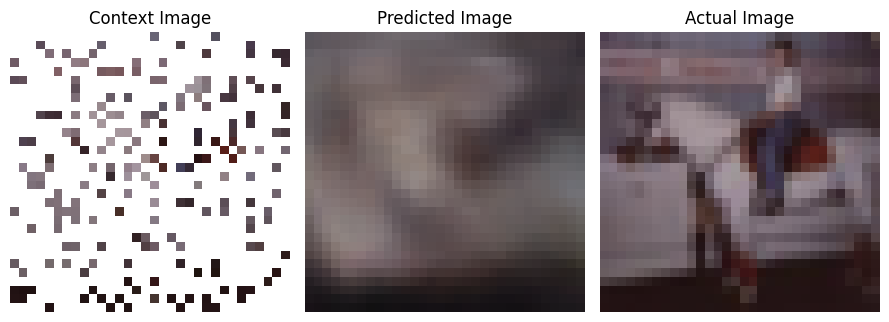

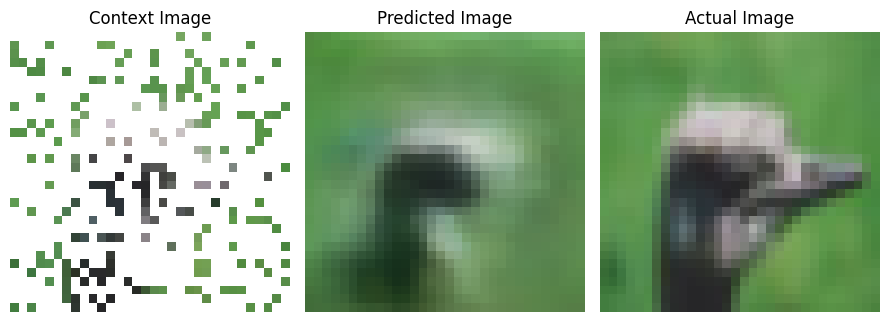

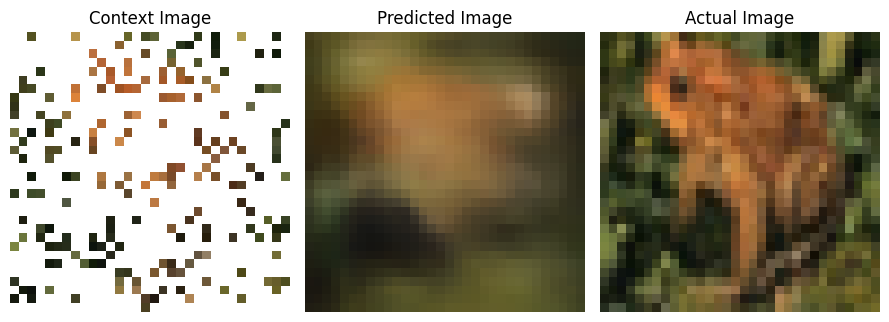

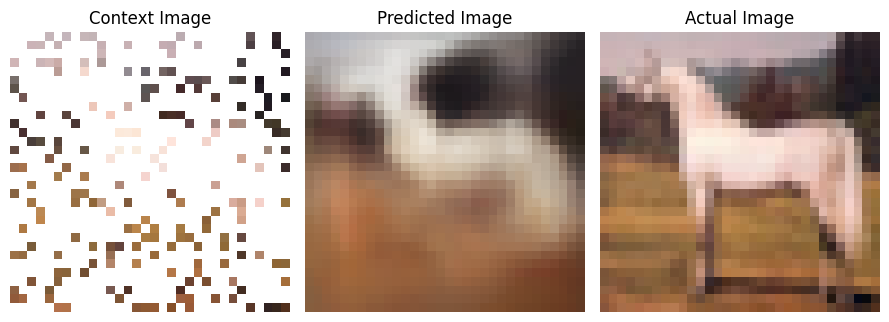

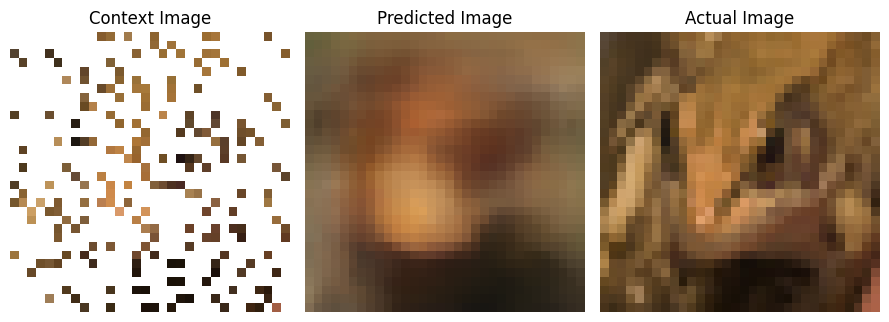

In [11]:
# testing the neural process.
for idx,(context_pairs, target_pairs) in enumerate(test_dataloader):
    context_pairs = context_pairs.to(device)
    target_pairs  = target_pairs.to(device)
    model.to(device)

    predicted_target_pixel_intensity = model(context_pairs, target_pairs)
    # for i in range(10):
    predicted_pixel = predicted_target_pixel_intensity.detach().cpu().numpy()
    predicted_image = predicted_pixel.reshape(32,32,3)

    actual_pixel = target_pairs[:,:,2:].detach().cpu().numpy()
    actual_image = actual_pixel.reshape(32,32,3)

    context_image = np.ones((32,32,3))
    context_pixel_locations = context_pairs[:,:,:2].detach().cpu().numpy().astype(int)
    context_image[context_pixel_locations[:,:,0], context_pixel_locations[:,:,1]] = context_pairs[:,:,2:].detach().cpu().numpy()
    # predicted_image[context_pixel_locations[:,:,0], context_pixel_locations[:,:,1]]= context_pairs[:,:,2:].detach().cpu().numpy()

    plt.figure(figsize=(9,4))

    plt.subplot(1,3,1)
    plt.imshow(context_image)
    plt.axis('off')
    plt.title('Context Image')
    
    plt.subplot(1,3,2)
    plt.imshow(predicted_image)
    plt.axis('off')
    plt.title('Predicted Image')

    plt.subplot(1,3,3)
    plt.imshow(actual_image)
    plt.axis('off')
    plt.title('Actual Image')
    
    plt.tight_layout()
    plt.show()

    if idx>3:
        break